In [ ]:
!pip install tensorflow

## Cargar imágenes

In [1]:
# conectar con google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Acceder a la carpeta donde están las imágenes y de donde las leeremos para entrenar el modelo

data_path = "/content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted/"

In [ ]:
import os

os.listdir(data_path)

['29566990_58680927_1000.1.jpg',
 '17011827_39323836_1000.1.jpg',
 '19004465_41555054_1000.jpg',
 '19365488_43299961_1000.jpg',
 '22870012_53110446_1000.jpg',
 '19768717_44253518_1000.jpg',
 '23041694_53226593_1000.jpg',
 '23134167_53391678_1000.jpg',
 '23351986_53494915_1000.jpg',
 '23389105_54580920_1000.jpg',
 '23497672_53590546_1000.jpg',
 '23652376_53879012_1000.jpg',
 '23729954_53829678_1000.jpg',
 '23797020_53768114_1000.jpg',
 '23776876_53703983_1000.jpg',
 '23819646_53938633_1000.jpg',
 '23810460_53901625_1000.jpg',
 '23900894_55265919_1000.jpg',
 '23975011_54134155_1000.jpg',
 '24005631_54146576_1000.jpg',
 '24206668_54327565_1000.jpg',
 '24305810_54399778_1000.jpg',
 '24269466_54325525_1000.jpg',
 '25481582_57429548_1000.jpg',
 '25793271_55976602_1000.jpg',
 '26437077_56065525_1000.jpg',
 '26420189_58057152_1000.jpg',
 '26684899_56380958_1000.jpg',
 '26903019_56468805_1000.jpg',
 '26987666_56529806_1000.jpg',
 '27186691_57055736_1000.jpg',
 '27148206_57056969_1000.jpg',
 '27

In [ ]:
from pathlib import Path
import imghdr

image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_path).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/tmp/ipython-input-5-1151986552.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
from PIL import Image
import os
from pathlib import Path

# Recorre todos los archivos dentro de la carpeta y subcarpetas
for subdir, _, files in os.walk(data_path):
    for file in files:
        file_path = os.path.join(subdir, file)
        file_ext = Path(file).suffix.lower()

        # Check for common image formats before converting
        if file_ext not in ['.png', '.jpg', '.jpeg', '.gif', '.bmp']:
            try:
                with Image.open(file_path) as img:
                    rgb_img = img.convert('RGB')  # Convierte a RGB por si tiene canal alpha o es .webp
                    new_file = Path(file_path).with_suffix('.png')
                    new_path = os.path.join(subdir, new_file.name)
                    rgb_img.save(new_path, 'PNG')
                    print(f"Convertido: {file_path} -> {new_path}")

                os.remove(file_path)  # Elimina el original si ya no lo necesitas
            except Exception as e:
                print(f"Error con {file_path}: {e}") # This will help identify problematic files.


Error con /content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted/fashion_images_converted-20250418T194457Z-001.zip: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/tfg/fashion_images/fashion_images_converted/fashion_images_converted-20250418T194457Z-001.zip'


## Preprocesamiento

In [ ]:
import tensorflow as tf

IMG_SIZE = 64
BATCH_SIZE = 128

dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode=None,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    interpolation='nearest' # Add this for better resize quality
)

# Change the data type of the images to tf.float32 before normalization
dataset = dataset.map(lambda x: tf.cast(x, tf.float32))

# Normalizar entre [-1, 1] como recomienda DCGAN
dataset = dataset.map(lambda x: (x / 127.5) - 1)
dataset = dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


Found 1843 files.


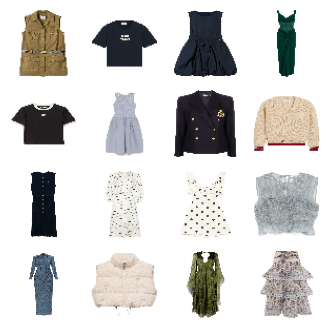

In [ ]:
import matplotlib.pyplot as plt

# Ejemplo para mostrar un batch de imágenes antes del entrenamiento
for images in dataset.take(1):
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        img = images[i].numpy()
        plt.imshow((img + 1) / 2)  # Si están en [-1, 1]
        plt.axis('off')
    plt.show()

## Generador y discriminador

In [ ]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


## Pérdida

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # 1 = real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # 0 = fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # queremos engañar al disc

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Parámetros
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

# Semilla fija para visualizar progreso
seed = tf.random.normal([num_examples_to_generate, noise_dim])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Entrenamiento

In [ ]:
import os
import time
from IPython import display
import matplotlib.pyplot as plt

# Función para generar y guardar imágenes
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2.0)  # Reescala de [-1, 1] a [0, 1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:03d}.png')
    plt.close()

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        # Generar imágenes
        generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}, Time: {time.time()-start:.2f}s')

    # Imagen final
    generate_and_save_images(generator, epochs, seed)


In [ ]:
train(dataset, EPOCHS)


Epoch 1, Gen Loss: 1.7522, Disc Loss: 0.3246, Time: 29.86s
Epoch 2, Gen Loss: 2.6605, Disc Loss: 0.1098, Time: 17.45s
Epoch 3, Gen Loss: 3.3096, Disc Loss: 0.0726, Time: 17.25s
Epoch 4, Gen Loss: 4.2394, Disc Loss: 0.0209, Time: 18.28s
Epoch 5, Gen Loss: 5.9183, Disc Loss: 0.0064, Time: 17.66s
Epoch 6, Gen Loss: 5.1525, Disc Loss: 0.0261, Time: 17.76s
Epoch 7, Gen Loss: 8.0023, Disc Loss: 0.0311, Time: 18.20s
Epoch 8, Gen Loss: 24.6383, Disc Loss: 0.1317, Time: 17.33s
Epoch 9, Gen Loss: 33.4854, Disc Loss: 0.0301, Time: 18.37s
Epoch 10, Gen Loss: 29.4195, Disc Loss: 0.0130, Time: 18.94s
Epoch 11, Gen Loss: 16.0444, Disc Loss: 0.0296, Time: 17.18s
Epoch 12, Gen Loss: 13.7795, Disc Loss: 0.1233, Time: 18.52s
Epoch 13, Gen Loss: 12.6929, Disc Loss: 0.0080, Time: 17.73s
Epoch 14, Gen Loss: 13.3771, Disc Loss: 0.1486, Time: 17.88s
Epoch 15, Gen Loss: 6.5545, Disc Loss: 0.0494, Time: 18.39s
Epoch 16, Gen Loss: 9.3885, Disc Loss: 0.0066, Time: 17.24s
Epoch 17, Gen Loss: 6.2942, Disc Loss: 0.0

## Guardar imágenes

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Ruta de destino en Google Drive
destination_folder = '/content/drive/MyDrive/Colab Notebooks/tfg/generated_images_model_1'

# Crear carpeta si no existe
os.makedirs(destination_folder, exist_ok=True)

# Directorio actual
current_dir = os.getcwd()

# Filtrar archivos .png en el directorio actual
png_files = [f for f in os.listdir(current_dir) if f.endswith('.png')]

# Copiar archivos .png al destino
for file_name in png_files:
    full_file_name = os.path.join(current_dir, file_name)
    shutil.copy(full_file_name, destination_folder)

print(f"Se copiaron {len(png_files)} archivos .png a {destination_folder}")


Se copiaron 20 archivos .png a /content/drive/MyDrive/Colab Notebooks/tfg/generated_images_model_1


## Mostrar resultados

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Extraer los archivos .png y el número en su nombre
def extract_number(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group()) if match else -1

# Filtrar y ordenar archivos por número extraído
def filter_and_sort_files(dir, n):
  png_files = [f for f in os.listdir(dir) if f.endswith('.png')]
  png_files = [f for f in png_files if extract_number(f) % n == 0]
  png_files = sorted(png_files, key=extract_number)

  # Mostrar en grid 4x4
  plt.figure(figsize=(12, 12))

  for i, file_name in enumerate(png_files):
      img = mpimg.imread(os.path.join(dir, file_name))
      plt.subplot(5, 5, i + 1)
      plt.imshow(img)
      plt.axis('off')
      plt.title(file_name, fontsize=8)

  plt.tight_layout()
  plt.show()

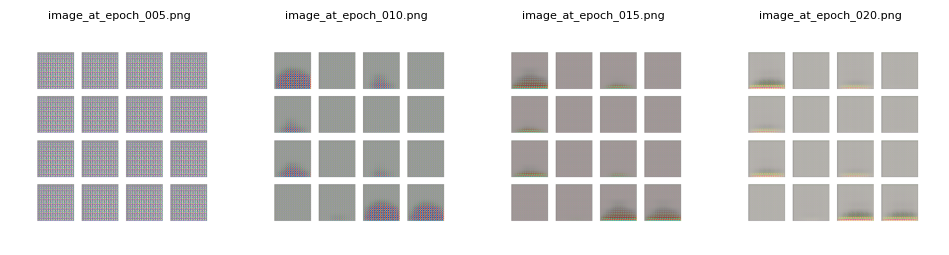

In [ ]:
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1'
filter_and_sort_files(dir, 5)

## GIF

In [3]:
import imageio
import glob
import os

anim_file = 'dcgan_model_1_gif.gif'
dir = '/content/drive/MyDrive/Colab Notebooks/tfg/DCGAN/generated_images_model_1'


with imageio.get_writer(anim_file, mode='I') as writer:
  # filenames = glob.glob('image*.png')
  filenames = glob.glob(os.path.join(dir, 'image*.png'))
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipython-input-3-797473694.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
